In [1]:
import os

current_path = os.getcwd()
print(current_path)


/fast/AG_Metzger/daniela/python


In [2]:
import torch

In [3]:
torch.cuda.is_available()

True

In [4]:
from fastai.vision.all import *
from sklearn.metrics import f1_score
import numpy as np
from fastcore import *

In [5]:
disease_path = Path('/fast/AG_Metzger/jakob/a728b741-9fed-4bfc-906f-5b828b882892/images/RGB_disease_tub_disease/')
wild_type_path = Path('/fast/AG_Metzger/jakob/a728b741-9fed-4bfc-906f-5b828b882892/images/RGB_wt_tub_wild_type/')

def get_label(o):
    if o.parent.name == 'RGB_disease_tub_disease':
        return 'disease'
    elif o.parent.name == 'RGB_wt_tub_wild_type':
        return 'wild_type'
    else:
        raise ValueError(f"Unknown label for {o}")

In [8]:
disease_files = get_image_files(disease_path)
wild_type_files = get_image_files(wild_type_path)

num_samples = min(len(disease_files), len(wild_type_files))
disease_files = disease_files[:num_samples]
wild_type_files = wild_type_files[:num_samples]

files = disease_files + wild_type_files
labels = {**{f:disease_path.name for f in disease_files}, **{f:wild_type_path.name for f in wild_type_files}}

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda x: files,
    splitter=RandomSplitter(valid_pct=0.3, seed=123),
    get_y=get_label,
    item_tfms=[Resize(224)],
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)]
)
dls = dblock.dataloaders(source=(disease_path, wild_type_path), bs=10, num_workers=4)

num_val_samples = len(dls.valid_ds)
if num_val_samples == 0:
    raise ValueError("Validation set is empty.")


learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(10, cbs=[EarlyStoppingCallback(patience=2)])
print(f'The accuracy of the model is {learn.recorder.values[-1][-1]:.2%}.')


val_indices = range_of(dls.valid)




val_files = [files[i] for i in val_indices]


val_preds = learn.get_preds(dl=dls.valid)




mean_preds = val_preds[0].mean()
std_preds = val_preds[0].std()



learn.export('model_tuned_single_tubd.pkl')

/home/mhernan/miniconda3/envs/gpuenv/lib/python3.9/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/mhernan/miniconda3/envs/gpuenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mhernan/miniconda3/envs/gpuenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The accuracy of the model is 99.38%.


In [9]:
val_preds, val_targs = learn.get_preds(dl=dls.valid)

df_valid = pd.DataFrame({'class': [dls.vocab[i] for i in val_targs], 'prediction': val_preds[:, 0]})

disease_preds = df_valid[df_valid['class'] == 'disease']['prediction']
wild_type_preds = df_valid[df_valid['class'] == 'wild_type']['prediction']
mean_disease, mean_wild_type = np.mean(disease_preds), np.mean(wild_type_preds)
std_disease, std_wild_type = np.std(disease_preds), np.std(wild_type_preds)

z_prime = 1 - 3*(std_disease + std_wild_type) / abs(mean_disease - mean_wild_type)

print(f'The Z prime score for the validation set is {z_prime:.2f}')

The Z prime score for the validation set is 0.62


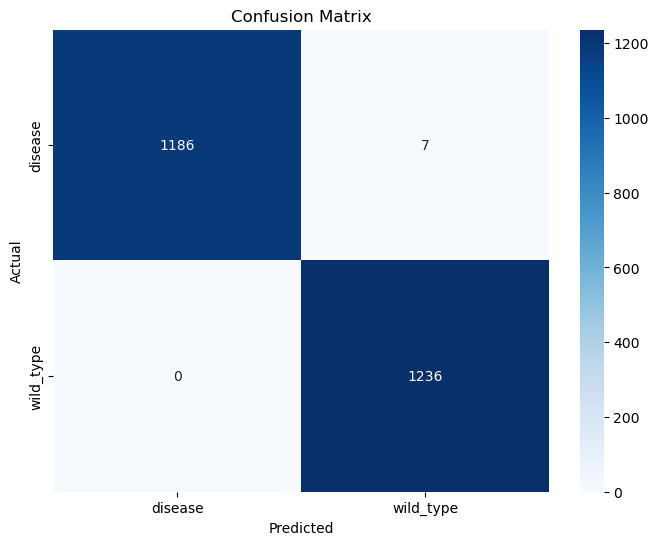

In [8]:
from fastai.learner import load_learner
from fastai.metrics import accuracy
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


model_path = Path('/fast/AG_Metzger/daniela/python/model_tuned_single_SMN.pkl')
learn = load_learner(model_path)


val_preds = learn.get_preds(dl=dls.valid)
val_labels = val_preds[1].tolist()
val_pred_labels = val_preds[0].argmax(dim=-1).tolist()


cm = confusion_matrix(val_labels, val_pred_labels)


classes = list(dls.vocab)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
#Rescue files analysis SMN channel

In [16]:
from fastai.learner import load_learner

model_path = Path('/fast/AG_Metzger/daniela/python/model_tuned_single_tubd.pkl')


learn = load_learner(model_path)

In [18]:
from fastai.vision.all import *
import dill

test_path = Path('/fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/RGB_rescue_tub_/')
model_path = Path('/fast/AG_Metzger/daniela/python/model_tuned_single_tubd.pkl')

learn_inf = load_learner(model_path, pickle_module=dill)

test_files = get_image_files(test_path)
test_dl = learn_inf.dls.test_dl(test_files)
preds, _ = learn_inf.get_preds(dl=test_dl)
pred_labels = preds.argmax(dim=1)


idx2label = {1: 'disease', 0: 'wild_type'}


results = []

for i, (pred_prob, pred_label_idx) in enumerate(zip(preds, pred_labels)):
    pred_label = idx2label[pred_label_idx.item()]
    probability = pred_prob[pred_label_idx].item()
    results.append({'File': test_files[i], 'Predicted Label': pred_label, 'Probability': probability})


df = pd.DataFrame(results)

print(df)

                                                                                                                                                          File   
0     /fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/RGB_rescue_tub_/r07c04_r07c04f03p32.tiff  \
1     /fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/RGB_rescue_tub_/r07c04_r07c04f22p33.tiff   
2     /fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/RGB_rescue_tub_/r07c04_r07c04f04p28.tiff   
3     /fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/RGB_rescue_tub_/r07c09_r07c09f08p09.tiff   
4     /fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/RGB_rescue_tub_/r07c07_r07c07f01p01.tiff   
...                         

In [19]:
learn_inf = load_learner(model_path, pickle_module=dill)

test_files = get_image_files(test_path)
test_dl = learn_inf.dls.test_dl(test_files)
preds, _ = learn_inf.get_preds(dl=test_dl)
pred_labels = preds.argmax(dim=1)


idx2label = {1: 'disease', 0: 'wild_type'}


results = []

for i, (pred_prob, pred_label_idx) in enumerate(zip(preds, pred_labels)):
    pred_label = idx2label[pred_label_idx.item()]
    probability = pred_prob[pred_label_idx].item()
    inverted_probability = 1 - probability 
    results.append({'File': test_files[i], 'Predicted Label': pred_label, 'Probability': probability, '1 - Probability': inverted_probability})


df = pd.DataFrame(results)


print(df)


                                                                                                                                                          File   
0     /fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/RGB_rescue_tub_/r07c04_r07c04f03p32.tiff  \
1     /fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/RGB_rescue_tub_/r07c04_r07c04f22p33.tiff   
2     /fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/RGB_rescue_tub_/r07c04_r07c04f04p28.tiff   
3     /fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/RGB_rescue_tub_/r07c09_r07c09f08p09.tiff   
4     /fast/AG_Metzger/jakob/Opera_files_Ines_Lahmann_rescue_experiment_20230328_2d844f7e-a828-416d-9999-61d8c44e7fcd/RGB_rescue_tub_/r07c07_r07c07f01p01.tiff   
...                         

In [20]:
treatment_mapping = {
    'c01': 'Control',
    'c02': 'Control',
    'c03': '250 nM Risdiplam',
    'c04': '250 nM Risdiplam',
    'c05': '250 nM Risdiplam',
    'c06': '250 nM Risdiplam',
    'c07': '10 uM Prednisolone',
    'c08': '10 uM Prednisolone',
    'c09': '10 uM Prednisolone + 250 nM Risdiplam'
}


common_names = [f.name.split('_')[0] for f in test_files]
treatments = []
for cn in common_names:
    for code, treatment in treatment_mapping.items():
        if code in cn:
            treatments.append(treatment)
            break
    else:
        treatments.append('Unknown')


df1 = pd.DataFrame({'Common Name': common_names,'Probability': df['Probability'], '1 - Probability': df['1 - Probability'], 'Treatment': treatments})


rescue_scores = df1.groupby('Treatment')['Probability'].mean().reset_index()

std_deviations = df1.groupby('Treatment')['Probability'].std().reset_index()


for treatment, score, std_dev in zip(rescue_scores['Treatment'], rescue_scores['Probability'], std_deviations['Probability']):
    print(f'Treatment: {treatment}, Rescue Score: {score:.4f}, Standard Deviation: {std_dev:.4f}')


Treatment: 10 uM Prednisolone, Rescue Score: 0.9848, Standard Deviation: 0.0507
Treatment: 10 uM Prednisolone + 250 nM Risdiplam, Rescue Score: 0.9789, Standard Deviation: 0.0715
Treatment: 250 nM Risdiplam, Rescue Score: 0.9851, Standard Deviation: 0.0504


/tmp/7158190.1.gpu.q/ipykernel_283517/1059444907.py:7: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=df1, x='1 - Probability', y='Treatment', palette=treatment_palette, alpha=0.8, marker='o', ax=ax)


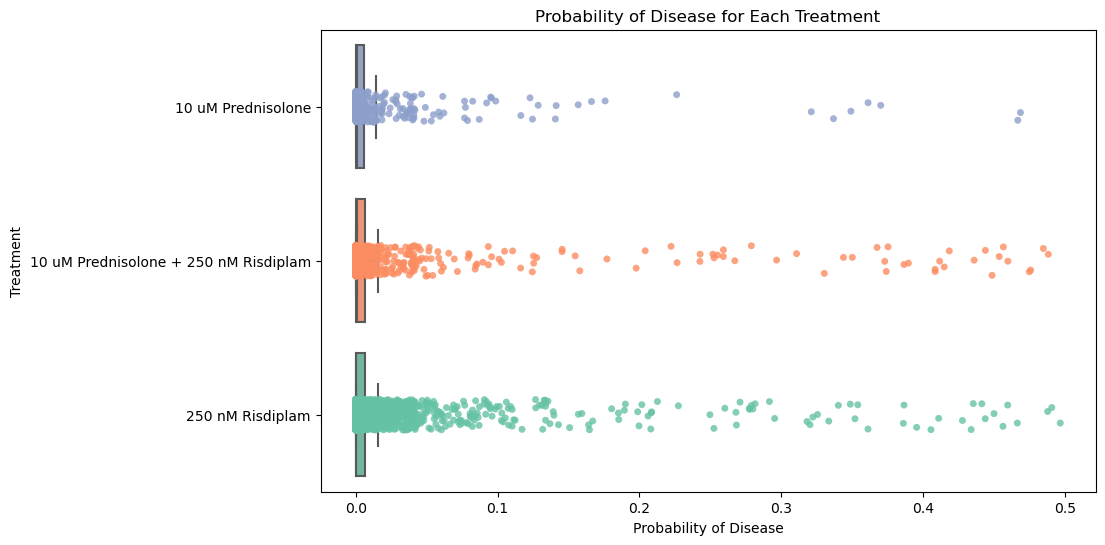

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
treatment_palette = sns.color_palette('Set2', n_colors=len(df1['Treatment'].unique()))
sns.boxplot(data=df1, x='1 - Probability', y='Treatment', ax=ax, showfliers=False, palette=treatment_palette)
sns.stripplot(data=df1, x='1 - Probability', y='Treatment', palette=treatment_palette, alpha=0.8, marker='o', ax=ax)
ax.set_xlabel('Probability of Disease')
ax.set_ylabel('Treatment')
ax.set_title('Probability of Disease for Each Treatment')
ax.invert_yaxis()
plt.show()


/tmp/7158190.1.gpu.q/ipykernel_283517/1592120092.py:4: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=df1, x='1 - Probability', y='Treatment', palette=treatment_palette, alpha=0.8, marker='o', ax=ax)


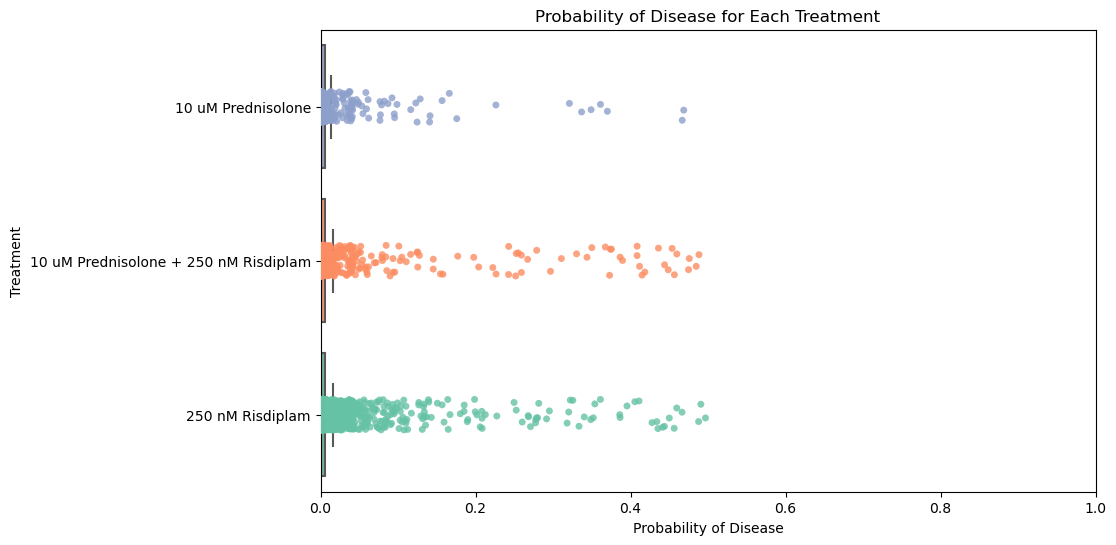

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
treatment_palette = sns.color_palette('Set2', n_colors=len(df1['Treatment'].unique()))
sns.boxplot(data=df1, x='1 - Probability', y='Treatment', ax=ax, showfliers=False, palette=treatment_palette)
sns.stripplot(data=df1, x='1 - Probability', y='Treatment', palette=treatment_palette, alpha=0.8, marker='o', ax=ax)
ax.set_xlabel('Probability of Disease')
ax.set_ylabel('Treatment')
ax.set_title('Probability of Disease for Each Treatment')
ax.invert_yaxis()
ax.set_xlim(0, 1)
plt.show()